#### Importing required dependencies and loading the data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from mgwr.gwr import GWR, MGWR, GWRResults
from mgwr.sel_bw import Sel_BW
from scipy import stats
import matplotlib.pyplot as plt



import seaborn as sns

import geopandas as gpd
%matplotlib inline
sns.set(color_codes=True)
from matplotlib_scalebar.scalebar import ScaleBar

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


gsv = pd.read_csv('./data/gsv_indicators_summarized_county.csv')
zipcode = pd.read_csv('./data/zip_code_database.csv')
census = pd.read_csv('./data/summary_zipcode_oct_1_2020.csv')

df = pd.read_csv('./data/ACSST1Y2021.S2504-Data.csv')

In [2]:
gsv = gsv.apply(lambda x: x * 100) # optimize code later
gsv['county'] = gsv.county//100

In [3]:
# gsv.head()

In [4]:
# df.head(2)

#### Select columns of interest from ACS census (apartments and county)

In [5]:
not_residential = df[['Geography','Estimate Percent occupied housing units Occupied housing units UNITS IN STRUCTURE 10 or more apartments']]

In [6]:
not_residential.rename(columns={'Estimate Percent occupied housing units Occupied housing units UNITS IN STRUCTURE 10 or more apartments':'apartments', 'Geography':'County'}, inplace=True)

In [7]:
not_residential['County'] = not_residential['County'].str.split('S', expand=True)[1]
not_residential['County'] = not_residential['County'].astype(int)

# not_residential.head()

In [8]:
# Merge df with GSV indicators

merged = gsv.merge(not_residential, left_on='county', right_on='County', how='inner')

In [9]:
# merged.head(3)

#### Load county dataset, then extract latitude and longitude centroids of each county

In [10]:
import geopandas as gpd
from geopandas import GeoDataFrame

counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty]

In [11]:
counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
counties_non_empty['id'] = counties_non_empty['id'].astype('int')

In [12]:
# counties_non_empty.head()

#### Merge all the dataframes to a single dataframe with relevant features

In [13]:
data = merged.merge(counties_non_empty, left_on='county', right_on='id', how='inner')

In [14]:
# data.head()

In [15]:
data.drop(['County', 'id', 'name'], axis=1, inplace=True)

In [16]:
data['apartments'] = data['apartments'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
data = data.dropna()

#### Prepare data for LCC

In [47]:
g_y = data['prop_crosswalk'].values.reshape((-1,1))
g_X = data[['apartments']].values

u = data['lon']
v = data['lat']

g_coords = list(zip(u,v))

data.head(2)

,county,prop_green,prop_crosswalk,prop_not_single_family_house,prop_single_lane,prop_triple_lane,prop_visible_wires,prop_sidewalk,prop_dilapidated_building,apartments,geometry,lon,lat,old_algo_params,textbook_calc,gwr_calc,new_algo_params
0,1003,94.701791,0.776435,11.609485,67.706725,0,43.61403,10.864435,9.718299,8.2,"POLYGON ((-88.00799 30.68468, -88.02593 30.753...",-87.723428,30.727208,0.0,0.0,0.528037,0.938795
1,1015,96.123673,0.675662,11.003635,74.779742,0,41.72571,8.514571,10.451194,4.2,"POLYGON ((-86.06618 33.84258, -85.99439 33.864...",-85.825913,33.771158,0.0,0.0,0.675464,0.805121


In [48]:
gdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes

# # gdf.plot(figsize=(50, 50))

# fig, ax = plt.subplots(figsize=(30,30))
# gdf.plot(ax=ax, color='tomato')
# minx, miny, maxx, maxy = gdf.total_bounds
# ax.set_xlim(minx, maxx)
# ax.set_ylim(miny, maxy)

#### Calculate LCC using the old algo `{standardize ---> weight}`

In [49]:
gwr_selector_o = Sel_BW(g_coords, g_y, g_X)
gwr_bw_o = gwr_selector_o.search()
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, constant=True, lwcc=False).fit()
gwr_results_o.summary()

64.0
Model type                                                         Gaussian
Number of observations:                                                 807
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            365.955
Log-likelihood:                                                    -825.990
AIC:                                                               1655.981
AICc:                                                              1658.011
BIC:                                                              -5022.170
R2:                                                                   0.547
Adj. R2:                                                              0.546

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

### GW - Correlation Coefficient


$$
   \frac{(x_j - \overline x_i)(y_j - \overline y_i) w_ij}{w_ij\sqrt (x_j - \overline x_i)^2 . \sqrt (y_j - \overline y_i)^2 }\
$$

From Page 162-163 of [GWR - The analysis of spatially varying relationships](https://www.academia.edu/33626785/Geographically_Weighted_Regression_The_Analysis_of_Spatially_Varying_Relationships_Wiley_2002)


In [50]:
for i in range(len(g_X)):
    wi = gwr_results_o.model._build_wi(i, gwr_bw_o).reshape(-1,1)
    x = g_X
    xi_mean = (x*wi).mean()
    y= g_y
    yi_mean = (y*wi).mean()
    numerator = wi*((x - xi_mean) * (y - yi_mean))
    denom = (wi*((np.sqrt((x - xi_mean)**2))) * ((np.sqrt((y - yi_mean)**2))))
    r = (numerator/denom)
    r[np.isnan(r)] = 0

    
r.mean()

0.07930607187112763

In [51]:
x_ = np.hstack((x,y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(807, 1))
sw = np.sum(wi)
wi = wi/sw

for i in range(len(g_X)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]


In [52]:
corr_mat.mean()

0.7119445670511535

## Cartography

#### Textbook LCC implemetation visualization

In [53]:
data['textbook_calc'] = r

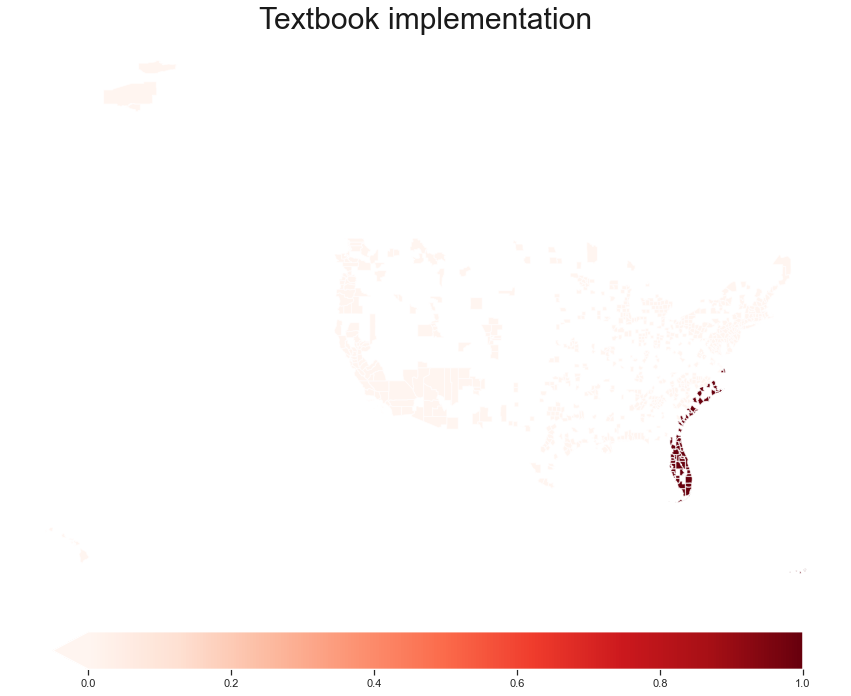

In [71]:
figsize=(14,10)
fig, ax = plt.subplots(1, figsize=(15, 15))

gdf.plot(column='textbook_calc', ax=ax, cmap='Reds', figsize=figsize, linewidth=0.5,)

ax.axis("off")

scatter = ax.collections[-1]
plt.colorbar(scatter, ax=ax, extend='min', orientation='horizontal', fraction=0.046, pad=0.04)
gdf.boundary.plot(ax=ax, color='white',alpha=0.2)


plt.title("Textbook implementation", fontsize='30', color='k')


plt.savefig("./images/textbook")

#### GWR implementation visualization

In [55]:
data['gwr_calc'] = corr_mat

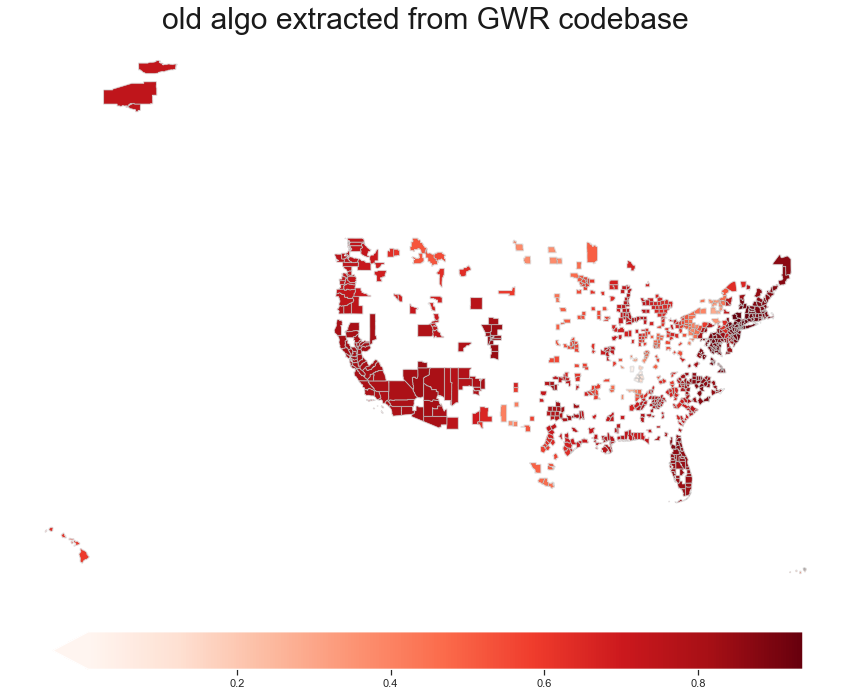

In [74]:
figsize=(14,10)
fig, ax = plt.subplots(1, figsize=(15, 15))

gdf.plot(column='gwr_calc', ax=ax, cmap='Reds', figsize=figsize, linewidth=0.5,)

ax.axis("off")

scatter = ax.collections[-1]
plt.colorbar(scatter, ax=ax, extend='min', orientation='horizontal', fraction=0.046, pad=0.04)
gdf.boundary.plot(ax=ax, color='gray',alpha=0.2)


plt.title("old algo extracted from GWR codebase", fontsize='30', color='k')


plt.savefig("./images/gwr_calc")

#### Calculate LCC using the new algo `{weight ---> standardize}`

In [57]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X)
gwr_bw_n = gwr_selector_n.search()
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit()
gwr_results_n.summary()

64.0
Model type                                                         Gaussian
Number of observations:                                                 807
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            973.639
Log-likelihood:                                                   -1220.827
AIC:                                                               2443.655
AICc:                                                              2445.670
BIC:                                                              -4421.179
R2:                                                                   0.536
Adj. R2:                                                              0.536

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- -

In [58]:
data['new_algo_params'] = gwr_results_n.params

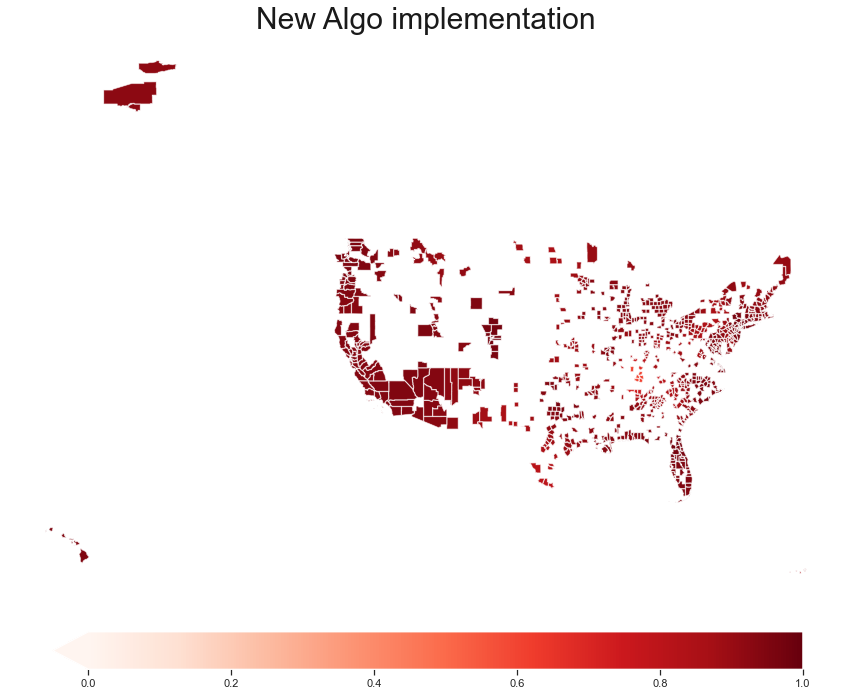

In [73]:
figsize=(14,10)
colors = 6
fig, ax = plt.subplots(1, figsize=(15, 15))

gdf.plot(column='new_algo_params', ax=ax, cmap='Reds', figsize=figsize, linewidth=0.5, vmin=0, vmax=1)

ax.axis("off")

scatter = ax.collections[-1]
plt.colorbar(scatter, ax=ax, extend='min', orientation='horizontal', fraction=0.046, pad=0.04)
gdf.boundary.plot(ax=ax,color='white',alpha=0.2)


plt.title("New Algo implementation", fontsize='30', color='k')


plt.savefig("./images/new_algo")

#### Locally weightedPeason's r Independently calculated

In [39]:
# corr = []

# for i in range(len(g_X)):
#     wi = gwr_results.model._build_wi(i, gwr_bw).reshape(-1,1)
#     xw = g_X*wi
#     yw = g_y*wi
#     corr_coef, _ = stats.pearsonr(xw.flatten(), yw.flatten())
#     corr.append(corr_coef)

# np.array(corr).mean()

#### Global correlation coefficient

In [40]:
# corr_g = []
# corr_coef, _ = stats.pearsonr(g_X.flatten(), g_y.flatten())
# corr_g.append(corr_coef)

In [41]:
# corr_g

#### Global Regression

In [42]:
# import statsmodels.api as sm
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# # xi =  g_X - g_X.mean(axis=0) / g_X.std(axis=0)
# # yi =  g_y - g_y.mean(axis=0) / g_y.std(axis=0)


# xi = scaler.fit_transform(g_X)
# yi = scaler.fit_transform(g_y)

# sm_results = sm.OLS(yi, xi).fit()

# sm_results.params

#### [Old Algo] Keep a random variable as the y for local_collinearity() 